In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import os
import zipfile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from mnist_skeptic_v9 import skeptic_v9

In [2]:
# Cell 1: Ensemble Model Creation and Prediction
class EnsembleModel(nn.Module):
    def __init__(self, model_paths):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList([skeptic_v9() for _ in range(len(model_paths))])
        for model, path in zip(self.models, model_paths):
            model.load_state_dict(torch.load(path))
            model.eval()

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        return torch.stack(outputs).mean(dim=0)

def create_ensemble(model_dir='best_boi_models'):
    model_paths = [os.path.join(model_dir, f) for f in os.listdir(model_dir) if f.endswith('.pth')]
    return EnsembleModel(model_paths)

ensemble_model = create_ensemble()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble_model.to(device)

C:\Users\Sai\AppData\Local\Temp\ipykernel_32548\3300162512.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


EnsembleModel(
  (models): ModuleList(
    (0-19): 20 x skeptic_v9(
      (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc1): Linear(in_features=512, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=10, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
)

In [3]:
# Cell 2: Data Loading Functions
def load_mnist_test_data():
    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
    return DataLoader(test_dataset, batch_size=64, shuffle=False)

def load_all_experimental_data(test_digits_folder):
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    participant_data = {}

    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) #PLEASE CHANGE THIS TO THE TRAINING NORMALIZATION VALUES (0.1307,), (0.3081,) IF YOU WANT TO USE THE TRAINING NORMALIZATION VALUES - ELSE (0.5,), (0.5,) WILL BE USED
    ])

    for filename in os.listdir(test_digits_folder):
        if filename.endswith('.zip') and filename.startswith('experiment_results_participant'):
            participant_number = int(filename.split('participant')[1].split('.')[0])
            zip_filepath = os.path.join(test_digits_folder, filename)

            participant_train_images = []
            participant_train_labels = []
            participant_test_images = []
            participant_test_labels = []

            with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
                for img_filename in zip_ref.namelist():
                    if img_filename.endswith('.png'):
                        with zip_ref.open(img_filename) as file:
                            img = Image.open(file).convert('L')  # Convert to grayscale
                            img_tensor = transform(img)
                            
                            digit = int(img_filename.split('_')[0])
                            
                            if 'composite' in img_filename:
                                test_images.append(img_tensor)
                                test_labels.append(digit)
                                participant_test_images.append(img_tensor)
                                participant_test_labels.append(digit)
                            else:
                                train_images.append(img_tensor)
                                train_labels.append(digit)
                                participant_train_images.append(img_tensor)
                                participant_train_labels.append(digit)

            participant_data[participant_number] = {
                'train': (torch.stack(participant_train_images), torch.tensor(participant_train_labels)),
                'test': (torch.stack(participant_test_images), torch.tensor(participant_test_labels))
            }

    print(f"Total training images: {len(train_images)}")
    print(f"Total test images: {len(test_images)}")
    
    for participant, data in participant_data.items():
        print(f"Participant {participant}:")
        print(f"  Training images: {len(data['train'][0])}")
        print(f"  Test images: {len(data['test'][0])}")

    return (torch.stack(train_images), torch.tensor(train_labels), 
            torch.stack(test_images), torch.tensor(test_labels),
            participant_data)

In [4]:
# Cell 3: Evaluation Functions

def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

def plot_confusion_matrix(true_labels, pred_labels, title):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def analyze_results(true_labels, pred_labels):
    accuracy = accuracy_score(true_labels, pred_labels)
    cm = confusion_matrix(true_labels, pred_labels)
    
    # Most confusable pairs
    n_classes = cm.shape[0]
    confusable_pairs = []
    for i in range(n_classes):
        for j in range(i+1, n_classes):
            if i != j:
                confusion_score = cm[i, j] + cm[j, i]
                confusable_pairs.append((i, j, confusion_score))
    confusable_pairs.sort(key=lambda x: x[2], reverse=True)
    
    # Most discriminable digits
    discriminability = np.diag(cm) / cm.sum(axis=1)
    most_discriminable = np.argsort(discriminability)[::-1]
    
    # Digits the model always guesses (potential overfitting)
    guess_bias = cm.sum(axis=0) / cm.sum()
    most_guessed = np.argsort(guess_bias)[::-1]
    
    return {
        'accuracy': accuracy,
        'num_evaluations': len(true_labels),
        'most_confusable': confusable_pairs[:5],
        'most_discriminable': most_discriminable[:5].tolist(),
        'most_guessed': most_guessed[:5].tolist()
    }

In [5]:
def main_evaluation():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ensemble_model = create_ensemble().to(device)
    
    # Evaluate on MNIST
    mnist_loader = load_mnist_test_data()
    mnist_preds, mnist_labels = evaluate_model(ensemble_model, mnist_loader, device)
    plot_confusion_matrix(mnist_labels, mnist_preds, "MNIST Confusion Matrix")
    
    mnist_results = analyze_results(mnist_labels, mnist_preds)
    print("\nMNIST Results:")
    print(f"Accuracy: {mnist_results['accuracy']:.4f}")
    print(f"Number of evaluations: {mnist_results['num_evaluations']}")
    print(f"Most confusable pairs: {mnist_results['most_confusable']}")
    print(f"Most discriminable digits: {mnist_results['most_discriminable']}")
    print(f"Most frequently guessed digits: {mnist_results['most_guessed']}")
    
    # Evaluate on Experimental Data
    exp_data = load_all_experimental_data('test_digits')
    _, _, exp_test_images, exp_test_labels, _ = exp_data
    
    exp_dataset = torch.utils.data.TensorDataset(exp_test_images, exp_test_labels)
    exp_loader = DataLoader(exp_dataset, batch_size=64, shuffle=False)
    
    exp_preds, exp_labels = evaluate_model(ensemble_model, exp_loader, device)
    plot_confusion_matrix(exp_labels, exp_preds, "Experimental Data Confusion Matrix")
    
    exp_results = analyze_results(exp_labels, exp_preds)
    print("\nExperimental Data Results:")
    print(f"Accuracy: {exp_results['accuracy']:.4f}")
    print(f"Number of evaluations: {exp_results['num_evaluations']}")
    print(f"Most confusable pairs: {exp_results['most_confusable']}")
    print(f"Most discriminable digits: {exp_results['most_discriminable']}")
    print(f"Most frequently guessed digits: {exp_results['most_guessed']}")

In [6]:
class ExperimentalDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

C:\Users\Sai\AppData\Local\Temp\ipykernel_32548\3300162512.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


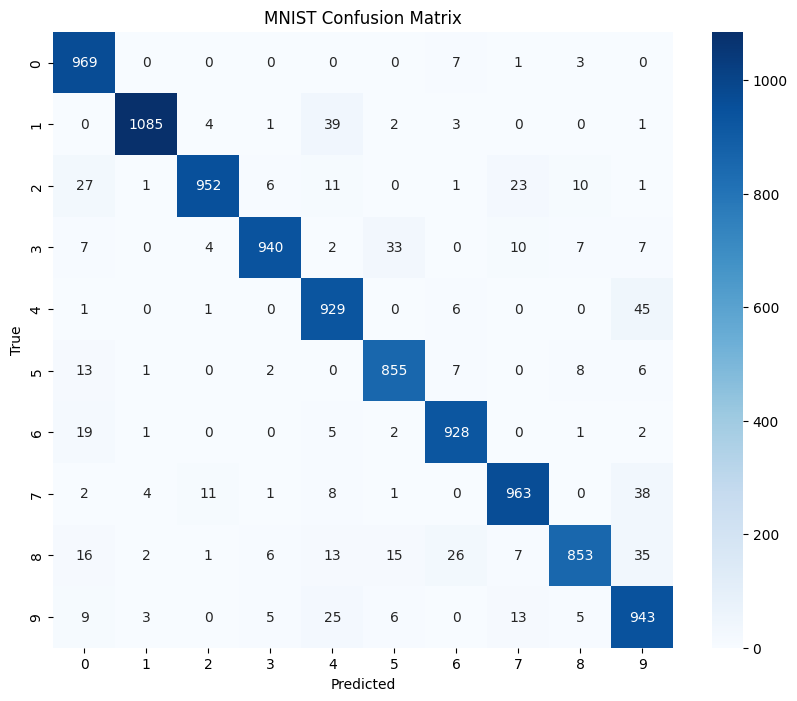


MNIST Results:
Accuracy: 0.9417
Number of evaluations: 10000
Most confusable pairs: [(4, 9, 70), (7, 9, 51), (8, 9, 40), (1, 4, 39), (3, 5, 35)]
Most discriminable digits: [0, 6, 5, 1, 4]
Most frequently guessed digits: [1, 9, 0, 4, 7]
Total training images: 31000
Total test images: 140
Participant 4:
  Training images: 1000
  Test images: 10
Participant 16:
  Training images: 1000
  Test images: 10
Participant 27:
  Training images: 1000
  Test images: 10
Participant 37:
  Training images: 5000
  Test images: 10
Participant 41:
  Training images: 5000
  Test images: 10
Participant 52:
  Training images: 2000
  Test images: 10
Participant 53:
  Training images: 1000
  Test images: 10
Participant 58:
  Training images: 1000
  Test images: 10
Participant 65:
  Training images: 1000
  Test images: 10
Participant 69:
  Training images: 5000
  Test images: 10
Participant 74:
  Training images: 1000
  Test images: 10
Participant 80:
  Training images: 5000
  Test images: 10
Participant 94:


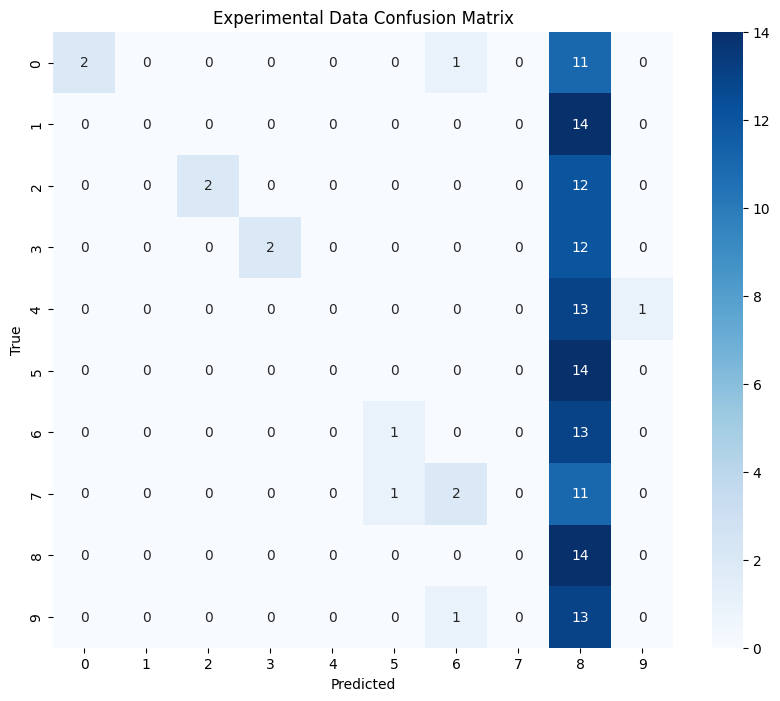


Experimental Data Results:
Accuracy: 0.1429
Number of evaluations: 140
Most confusable pairs: [(1, 8, 14), (5, 8, 14), (4, 8, 13), (6, 8, 13), (8, 9, 13)]
Most discriminable digits: [8, 3, 2, 0, 9]
Most frequently guessed digits: [8, 6, 5, 3, 2]


In [9]:
# Run the main evaluation
main_evaluation()

You're on the right track with your analysis. Let's break down the MNIST results and interpret them:

1. Accuracy:
The model achieves 94.17% accuracy on the MNIST test set, which is indeed promising. This indicates that the model performs well on standard, clean digit images.

2. Most confusable pairs:
The pairs (4, 9), (7, 9), (8, 9), (1, 4), and (3, 5) are the most frequently confused. This makes sense as these digit pairs can look similar, especially in handwritten form.

3. Most discriminable digits:
[0, 6, 5, 1, 4] are the digits the model can identify most accurately.

4. Most frequently guessed digits:
[1, 9, 0, 4, 7] are the digits the model predicts most often, which could indicate a slight bias towards these digits.

Your observation about the most discriminable digits is insightful. Indeed, 6 and 5 appear in the most discriminable list but not in the most frequently guessed list. This suggests that when the model predicts a 6 or a 5, it's highly likely to be correct, and it's not overguessing these digits.

Regarding the "most confusable digit overall," there isn't a single metric for this in the provided data, but we can infer it by looking at which digits appear most frequently in the confusable pairs:

- 9 appears in three pairs (4-9, 7-9, 8-9)
- 4 appears in two pairs (4-9, 1-4)
- 3, 5, 7, 8, and 1 each appear in one pair

Based on this, we could say that 9 is the "most confusable digit overall" as it's involved in the most confusable pairs. This makes sense intuitively, as 9 can be easily confused with 4, 7, and 8 in handwritten form.

To get a more comprehensive view of the "most confusable digit overall," you could:

1. Sum up all the confusion scores for each digit across all pairs.
2. Look at the off-diagonal elements in the confusion matrix for each digit.
3. Calculate a "confusability score" for each digit by summing all instances where it was confused with another digit or another digit was confused with it.

These approaches would give you a more quantitative measure of overall confusability for each digit.

C:\Users\Sai\AppData\Local\Temp\ipykernel_32548\3300162512.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


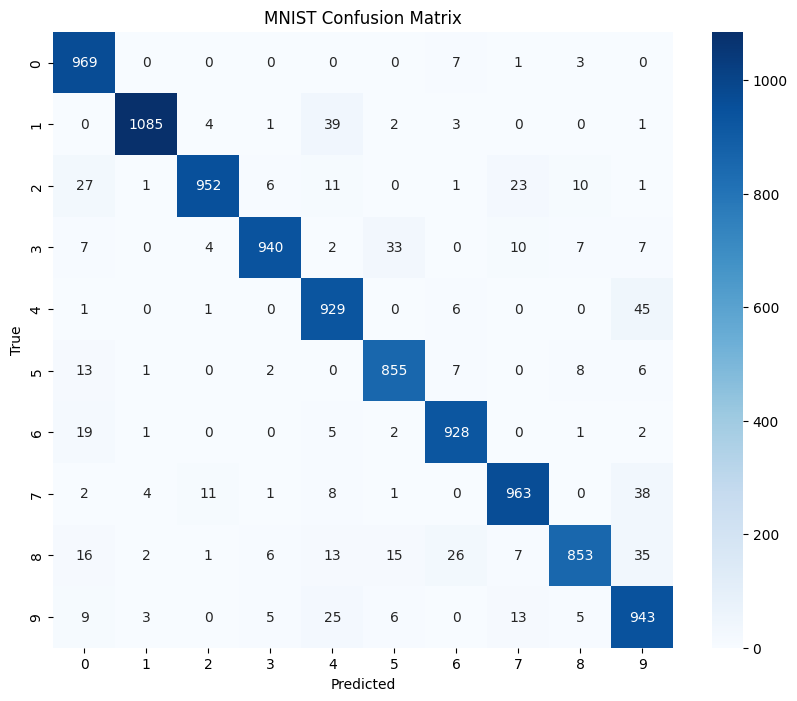


MNIST Results:
Accuracy: 0.9417
Number of evaluations: 10000
Most confusable pairs: [(4, 9, 70), (7, 9, 51), (8, 9, 40), (1, 4, 39), (3, 5, 35)]
Most discriminable digits: [0, 6, 5, 1, 4]
Most frequently guessed digits: [1, 9, 0, 4, 7]
Confusability scores (digit: score):
  9: 0.1992
  8: 0.1591
  4: 0.1589
  7: 0.1158
  5: 0.1076
  0: 0.1071
  2: 0.0979
  3: 0.0901
  6: 0.0835
  1: 0.0546
Total training images: 31000
Total test images: 140
Participant 4:
  Training images: 1000
  Test images: 10
Participant 16:
  Training images: 1000
  Test images: 10
Participant 27:
  Training images: 1000
  Test images: 10
Participant 37:
  Training images: 5000
  Test images: 10
Participant 41:
  Training images: 5000
  Test images: 10
Participant 52:
  Training images: 2000
  Test images: 10
Participant 53:
  Training images: 1000
  Test images: 10
Participant 58:
  Training images: 1000
  Test images: 10
Participant 65:
  Training images: 1000
  Test images: 10
Participant 69:
  Training images

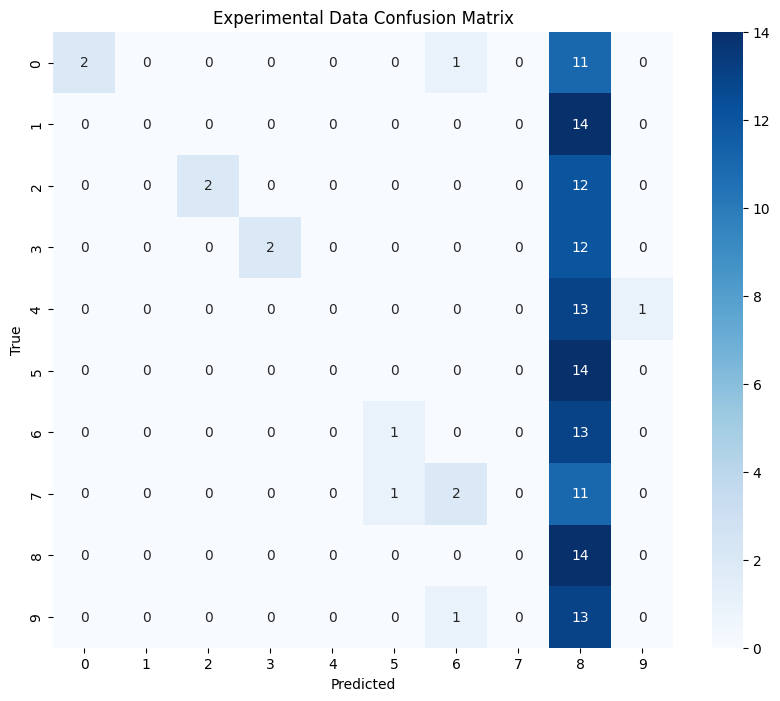


Experimental Data Results:
Accuracy: 0.1429
Number of evaluations: 140
Most confusable pairs: [(1, 8, 14), (5, 8, 14), (4, 8, 13), (6, 8, 13), (8, 9, 13)]
Most discriminable digits: [8, 3, 2, 0, 9]
Most frequently guessed digits: [8, 6, 5, 3, 2]
Confusability scores (digit: score):
  8: 8.0714
  6: 1.2857
  5: 1.1429
  9: 1.0714
  1: 1.0000
  4: 1.0000
  7: 1.0000
  0: 0.8571
  2: 0.8571
  3: 0.8571


In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_confusability_scores(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    n_classes = cm.shape[0]
    
    confusability_scores = {}
    
    for digit in range(n_classes):
        # Sum of cases where this digit was confused for another
        confused_for_others = cm[digit, :].sum() - cm[digit, digit]
        
        # Sum of cases where other digits were confused for this one
        others_confused_for_this = cm[:, digit].sum() - cm[digit, digit]
        
        # Total confusability score
        total_confusions = confused_for_others + others_confused_for_this
        
        # Normalize by the total number of true instances of this digit
        confusability_score = total_confusions / cm[digit, :].sum()
        
        confusability_scores[digit] = confusability_score
    
    # Sort digits by confusability score in descending order
    sorted_scores = sorted(confusability_scores.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_scores

def analyze_results(true_labels, pred_labels):
    accuracy = accuracy_score(true_labels, pred_labels)
    cm = confusion_matrix(true_labels, pred_labels)
    
    # Most confusable pairs
    n_classes = cm.shape[0]
    confusable_pairs = []
    for i in range(n_classes):
        for j in range(i+1, n_classes):
            if i != j:
                confusion_score = cm[i, j] + cm[j, i]
                confusable_pairs.append((i, j, confusion_score))
    confusable_pairs.sort(key=lambda x: x[2], reverse=True)
    
    # Most discriminable digits
    discriminability = np.diag(cm) / cm.sum(axis=1)
    most_discriminable = np.argsort(discriminability)[::-1]
    
    # Digits the model always guesses (potential overfitting)
    guess_bias = cm.sum(axis=0) / cm.sum()
    most_guessed = np.argsort(guess_bias)[::-1]
    
    # Calculate confusability scores
    confusability_scores = calculate_confusability_scores(true_labels, pred_labels)
    
    return {
        'accuracy': accuracy,
        'num_evaluations': len(true_labels),
        'most_confusable': confusable_pairs[:5],
        'most_discriminable': most_discriminable[:5].tolist(),
        'most_guessed': most_guessed[:5].tolist(),
        'confusability_scores': confusability_scores
    }

def main_evaluation():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ensemble_model = create_ensemble().to(device)
    
    # Evaluate on MNIST
    mnist_loader = load_mnist_test_data()
    mnist_preds, mnist_labels = evaluate_model(ensemble_model, mnist_loader, device)
    plot_confusion_matrix(mnist_labels, mnist_preds, "MNIST Confusion Matrix")
    
    mnist_results = analyze_results(mnist_labels, mnist_preds)
    print("\nMNIST Results:")
    print(f"Accuracy: {mnist_results['accuracy']:.4f}")
    print(f"Number of evaluations: {mnist_results['num_evaluations']}")
    print(f"Most confusable pairs: {mnist_results['most_confusable']}")
    print(f"Most discriminable digits: {mnist_results['most_discriminable']}")
    print(f"Most frequently guessed digits: {mnist_results['most_guessed']}")
    print("Confusability scores (digit: score):")
    for digit, score in mnist_results['confusability_scores']:
        print(f"  {digit}: {score:.4f}")
    
    # Evaluate on Experimental Data
    exp_data = load_all_experimental_data('test_digits')
    _, _, exp_test_images, exp_test_labels, _ = exp_data
    
    exp_dataset = torch.utils.data.TensorDataset(exp_test_images, exp_test_labels)
    exp_loader = DataLoader(exp_dataset, batch_size=64, shuffle=False)
    
    exp_preds, exp_labels = evaluate_model(ensemble_model, exp_loader, device)
    plot_confusion_matrix(exp_labels, exp_preds, "Experimental Data Confusion Matrix")
    
    exp_results = analyze_results(exp_labels, exp_preds)
    print("\nExperimental Data Results:")
    print(f"Accuracy: {exp_results['accuracy']:.4f}")
    print(f"Number of evaluations: {exp_results['num_evaluations']}")
    print(f"Most confusable pairs: {exp_results['most_confusable']}")
    print(f"Most discriminable digits: {exp_results['most_discriminable']}")
    print(f"Most frequently guessed digits: {exp_results['most_guessed']}")
    print("Confusability scores (digit: score):")
    for digit, score in exp_results['confusability_scores']:
        print(f"  {digit}: {score:.4f}")

# Run the main evaluation
main_evaluation()

This implementation adds a new function `calculate_confusability_scores` that computes a confusability score for each digit. The score is calculated as follows:

1. For each digit, we sum up all cases where it was confused for another digit and all cases where other digits were confused for it.
2. We normalize this sum by the total number of true instances of the digit.
3. The result is a score between 0 and 2, where 0 means the digit is never confused, and higher values indicate more confusion.

The `analyze_results` function now includes these confusability scores in its output.

The `main_evaluation` function has been updated to print these confusability scores for both MNIST and experimental data.

This implementation will give you a more comprehensive view of which digits are most confusable overall, taking into account both when a digit is mistaken for others and when others are mistaken for it. The scores are sorted in descending order, so the digits with the highest confusability scores will be listed first.

To not waste too much time we are going to make it evaluate another 10,000 MNIST but with whitenoise - let's see if we can still justify the 6/9 pairing 

C:\Users\Sai\AppData\Local\Temp\ipykernel_32548\3300162512.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Accuracy on Noisy MNIST: 0.3956


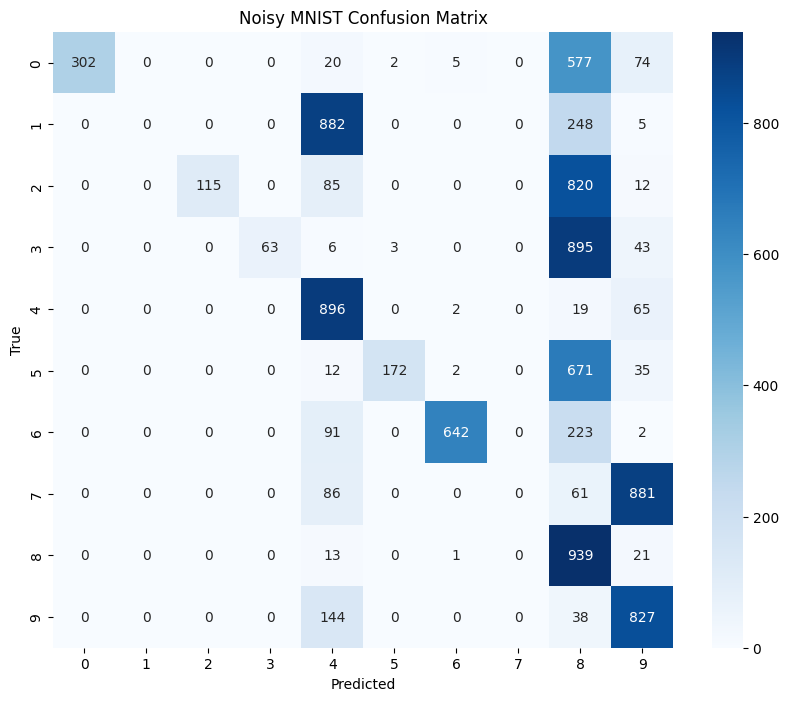

Noisy MNIST Analysis:
Most confusable pairs: [(3, 8, 895), (1, 4, 882), (7, 9, 881), (2, 8, 820), (5, 8, 671)]
Most discriminable digits: [8 4 9 6 0]
Most frequently guessed digits: [8 4 9 6 0]


In [11]:
def add_noise(image, noise_factor=0.5):
    noisy_image = image + noise_factor * torch.randn(image.size())
    return torch.clamp(noisy_image, 0., 1.)

class NoisyMNISTDataset(Dataset):
    def __init__(self, mnist_dataset, noise_factor=0.5):
        self.mnist_dataset = mnist_dataset
        self.noise_factor = noise_factor

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        noisy_image = add_noise(image, self.noise_factor)
        return noisy_image, label

def load_noisy_mnist_test_data(noise_factor=0.5):
    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    mnist_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
    noisy_dataset = NoisyMNISTDataset(mnist_dataset, noise_factor)
    return DataLoader(noisy_dataset, batch_size=64, shuffle=False)

def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

def plot_confusion_matrix(true_labels, pred_labels, title):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def analyze_confusion(cm):
    n_classes = cm.shape[0]
    
    # Most confusable pairs
    confusable_pairs = []
    for i in range(n_classes):
        for j in range(i+1, n_classes):
            if i != j:
                confusion_score = cm[i, j] + cm[j, i]
                confusable_pairs.append((i, j, confusion_score))
    
    confusable_pairs.sort(key=lambda x: x[2], reverse=True)
    
    # Most discriminable digits
    discriminability = np.diag(cm) / cm.sum(axis=1)
    most_discriminable = np.argsort(discriminability)[::-1]
    
    # Digits the model always guesses (overfitting)
    guess_bias = cm.sum(axis=0) / cm.sum()
    most_guessed = np.argsort(guess_bias)[::-1]
    
    return confusable_pairs[:5], most_discriminable[:5], most_guessed[:5]

def main_evaluation():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ensemble_model = create_ensemble().to(device)
    
    # Evaluate on Noisy MNIST
    noisy_mnist_loader = load_noisy_mnist_test_data(noise_factor=0.5)
    noisy_mnist_preds, noisy_mnist_labels = evaluate_model(ensemble_model, noisy_mnist_loader, device)
    
    # Calculate accuracy
    accuracy = (noisy_mnist_preds == noisy_mnist_labels).mean()
    print(f"Accuracy on Noisy MNIST: {accuracy:.4f}")
    
    plot_confusion_matrix(noisy_mnist_labels, noisy_mnist_preds, "Noisy MNIST Confusion Matrix")
    
    # Analyze Noisy MNIST results
    noisy_mnist_cm = confusion_matrix(noisy_mnist_labels, noisy_mnist_preds)
    noisy_mnist_confusable, noisy_mnist_discriminable, noisy_mnist_guessed = analyze_confusion(noisy_mnist_cm)
    
    print("Noisy MNIST Analysis:")
    print("Most confusable pairs:", noisy_mnist_confusable)
    print("Most discriminable digits:", noisy_mnist_discriminable)
    print("Most frequently guessed digits:", noisy_mnist_guessed)

if __name__ == "__main__":
    main_evaluation()